In [1]:
%load_ext autoreload
%autoreload 2 

* 이미지를 VAE로 Embedding하여 얻은 vector의 similarity와 풍속데이터의 Similarity 비교
* 체크해야 할 것
    - 풍속기록이 있는 데이터만 필요하며, 일부는 Train 일부는 test 이를 구분해야 할 필요가 있음

In [2]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from collections import OrderedDict

import yaml
import torch
from torchvision import transforms, datasets
from torch.utils.data import SubsetRandomSampler, DataLoader, TensorDataset

from models import *
from src import *

In [3]:
# Wind data load

with open('../../Share_Data/windspeed/_Main_dataset.pickle', 'rb') as f:
    windspeed_dataset = pickle.load(f)
    
station_list = list(windspeed_dataset.keys())
windspeed_list = []
for item in windspeed_dataset.values():
    windspeed_list.append(item[3])
windspeed_list = np.array(windspeed_list)

In [4]:
# load config
config_path = 'configs/betatc_vae_sate.yaml'
checkpoint_path = '../../Share_Data/logs/BetaTCVAE_CART/dd355867e6f84e798c2f7558264493a9/epoch=595.ckpt'

with open(config_path, 'rb') as f:
    config = yaml.safe_load(f)

#load vae model
model = vae_models[config['model_params']['name']](**config['model_params'])
untrained_model = vae_models[config['model_params']['name']](**config['model_params'])

#checkpoint load
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu')) # when using CPU
new_state_dict = OrderedDict()
for k, v in checkpoint['state_dict'].items():
    name = k[6:]
    new_state_dict[name] = v
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [5]:
# load img data

IMG_PATH = '../../Share_Data/satellite/jpg_cart_all_d10/_jpg_cart_d10/{}.jpg'

img_list =[ ]
label_list = []
for station_code in station_list:
    img = Image.open(IMG_PATH.format(station_code)).resize([config['exp_params']['img_size']]*2)
    img_list.append(np.array(img))
    label_list.append(station_code)

img_list = (np.array(img_list)/255.)*2-1
tensor_img = torch.Tensor(img_list).permute(0,3,1,2)
tensor_dataset = TensorDataset(tensor_img)
dataloader = DataLoader(tensor_img)

In [6]:
x, y, mu, log_var, z = model.forward(tensor_img)
_, _, untrained_mu, untrained_log_var, untrained_z = untrained_model.forward(tensor_img)

print('size of latent vector, z : {}'.format(z.size()))

size of latent vector, z : torch.Size([349, 32])


---
### Test reconstruct

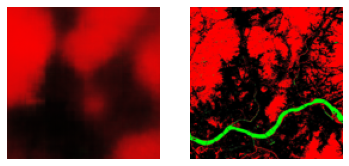

In [43]:
fig_num = 23

plt.subplot(1,2,1)
plt.imshow(((x[fig_num]+1)/2).permute(1,2,0).detach().numpy())
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(((y[fig_num]+1)/2).permute(1,2,0).detach().numpy())
plt.axis('off')
plt.show()

### Analysis

In [8]:
#windspeed difference matrix

windspeed_diff_list = []
for i in windspeed_list:
    temp_list = []
    for j in windspeed_list:
        temp_list.append(abs(i-j))
    windspeed_diff_list.append(temp_list)
windspeed_diff_list = np.array(windspeed_diff_list)

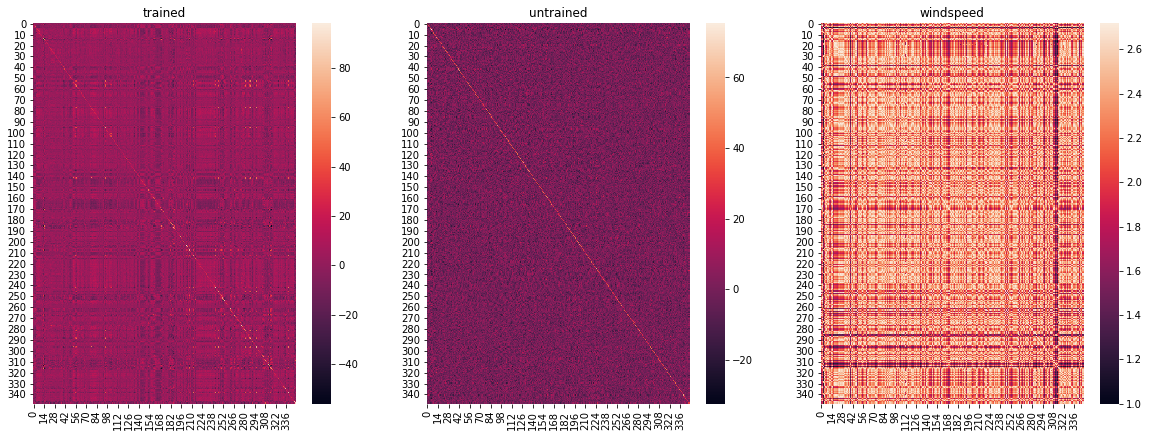

In [9]:
cov = torch.mm(z, z.t().contiguous())
untrained_cov = torch.mm(untrained_z, untrained_z.t().contiguous())

windspeed_diff = np.exp(-windspeed_diff_list/windspeed_diff_list.max()+1)


plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
plt.title('trained')
sns.heatmap(cov.detach().numpy())

plt.subplot(1,3,2)
plt.title('untrained')
sns.heatmap(untrained_cov.detach().numpy())

plt.subplot(1,3,3)
plt.title('windspeed')
sns.heatmap(windspeed_diff)
plt.show()

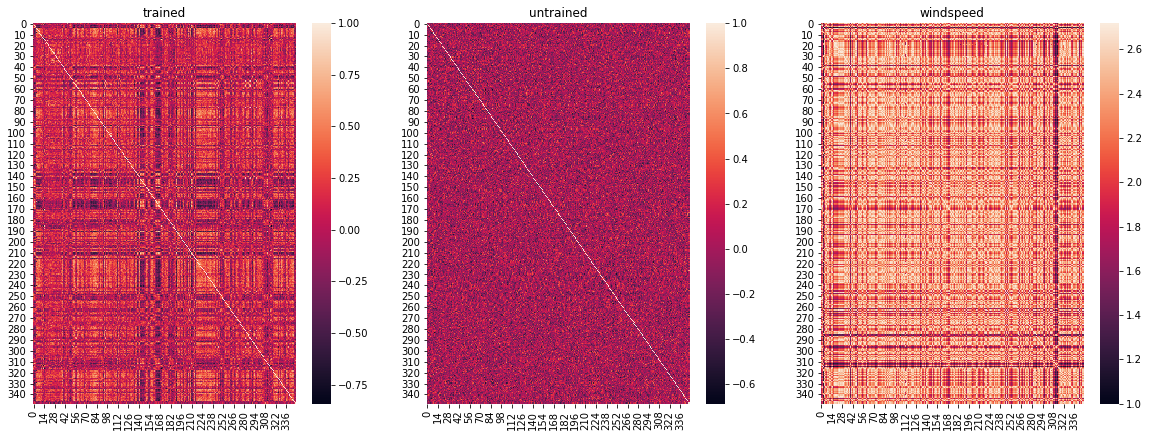

In [10]:
z_n = z.norm(dim=1)[:,None]
z_n = torch.max(z_n, 1e-8*torch.ones_like(z_n))

untrained_z_n = untrained_z.norm(dim=1)[:,None]
untrained_z_n = torch.max(untrained_z_n, 1e-8*torch.ones_like(untrained_z_n))

cov = torch.mm(z/z_n, (z/z_n).t().contiguous())
untrained_cov = torch.mm(untrained_z/untrained_z_n, (untrained_z/untrained_z_n).t().contiguous())

windspeed_diff = np.exp(-windspeed_diff_list/windspeed_diff_list.max()+1)


plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
plt.title('trained')
sns.heatmap(cov.detach().numpy())

plt.subplot(1,3,2)
plt.title('untrained')
sns.heatmap(untrained_cov.detach().numpy())

plt.subplot(1,3,3)
plt.title('windspeed')
sns.heatmap(windspeed_diff)
plt.show()

---
# REPORT

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [12]:
with open('../../Share_Data/windspeed/rgb_d5_label.pickle', 'rb') as f:
    label = pickle.load(f)
    
label_pd = pd.DataFrame(label).set_index(0)

In [13]:
select_label = []
for i in list(windspeed_dataset):
    select_label.append(int(label_pd.loc[i][1]))

In [14]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(z.detach().numpy())

In [15]:
kmeans.labels_

array([0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0,
       0, 0, 0, 0, 2, 2, 2, 2, 0, 1, 0, 0, 1, 1, 1, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2,
       0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0,
       2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 1, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       1, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 2, 2, 0, 0, 0, 0, 1, 0, 0, 0,

In [17]:
print(select_label)

[3, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 3, 2, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 4, 4, 3, 3, 3, 2, 3, 3, 4, 4, 4, 3, 3, 4, 2, 2, 2, 4, 4, 2, 2, 4, 3, 3, 2, 2, 2, 2, 4, 3, 3, 2, 3, 3, 3, 3, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 3, 3, 3, 4, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 4, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 2, 3, 2, 2, 2, 3, 3, 3, 4, 2, 3, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 3, 4, 2, 3, 4, 3, 4, 3, 3, 3, 2, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 2, 3, 3, 3, 4, 3, 4, 4, 4, 3, 4, 4, 3, 3, 3, 3, 2, 4, 2, 3, 2, 2, 4, 3, 3, 2, 4, 3, 3, 3, 4, 4, 4, 2, 4, 2, 4, 4, 4, 4, 2, 2, 4, 3, 3, 2, 3, 2, 3, 2, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 4, 2, 2, 4, 4, 4, 4, 4, 4, 2, 2, 3, 4, 3, 3, 3, 4, 4, 4, 4, 2, 4, 4, 2, 3, 2, 4, 3, 3, 3, 4, 3, 2, 2, 2, 2, 4, 3, 3, 3, 2, 3, 3, 4, 3, 4, 4, 3, 2, 3, 3, 4, 3, 3, 2, 3, 3, 4, 3, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 2, 2, 2, 3, 3, 4, 3, 3, 3, 3, 3, 3, 

* 오 뭔가 비슷한데...?
* 눈으로 보기엔 2 <- 1 / 4<-2 / 3<-0 인듯

In [18]:
change_list = [3, 2, 4]
kmeans_label = list(map(lambda x:change_list[x], kmeans.labels_))    

In [19]:
select_label = np.array(select_label).reshape(-1,1)
kmeans_label = np.array(kmeans_label).reshape(-1,1)

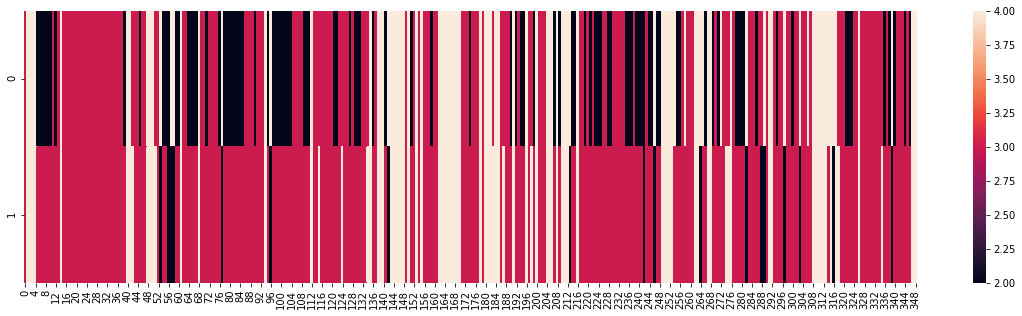

In [20]:
plt.figure(figsize=(20,5))
sns.heatmap(np.concatenate([select_label, kmeans_label], axis=-1).T)
plt.show()

In [21]:
print('difference : {}'.format(sum(select_label != kmeans_label)))

difference : [131]


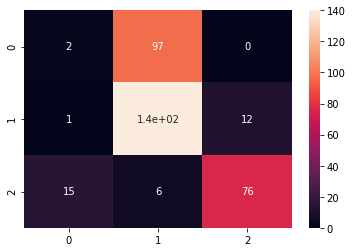

In [22]:
sns.heatmap(confusion_matrix(select_label, kmeans_label), annot=True)
plt.show()

### 나름 의미 있는 결과 같은데,
* ?? 컴퓨터야 왜 1,2번을 전혀 구분하지 못하는 것인가